Classification of recycling waste into different classes.
Use the TrashNet (resized) dataset.

In [1]:
import os

In [2]:
dataset = '/home/tensorflow/waste/datasets/trashnet-resized/'

In [3]:
non_trash_images = {}
for folder in os.listdir(dataset):
    if folder == 'trash': continue
    non_trash_images[folder] = []
    for img_name in os.listdir(os.path.join(dataset, folder)):
        non_trash_images[folder].append(
                    os.path.join(dataset, folder, img_name))

In [4]:
import matplotlib.pyplot as plt

In [8]:
trash_categories = list(non_trash_images.keys())

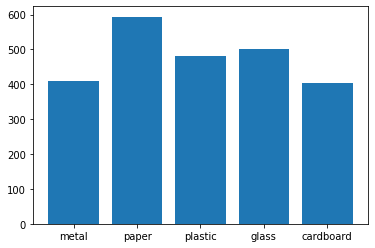

In [9]:
plt.bar(range(len(non_trash_images)), [len(cat) for cat in non_trash_images.values()])
_=plt.xticks(range(len(non_trash_images)), trash_categories)

Split into training (80), validation (5), test (15).

In [11]:
train_imgs = {}
valid_imgs = {}
test_imgs = {}
PERC_TRAIN = 0.8
PERC_VALID = 0.05
PERC_TEST = 0.15
for cat, imgs in non_trash_images.items():
    train_size = int(PERC_TRAIN*len(imgs))
    train_imgs[cat] = imgs[:train_size]
    valid_size = int(PERC_VALID*len(imgs))
    valid_imgs[cat] = imgs[train_size:train_size+valid_size]
    test_imgs[cat] = imgs[train_size+valid_size:]

Create TFRecords from the data

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
import io
from PIL import Image

In [17]:
def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def write_to_tfrecord(writer, imgs, cat, catidx):
    """Write images of the given category to the TF record with writer"""
    for img_path in imgs:
        # Process the image
        with tf.io.gfile.GFile(img_path, 'rb') as fid:
            img_data = fid.read()
        img_data_io = io.BytesIO(img_data)
        image = Image.open(img_data_io)
        image = image.resize((227,227))
        width, height = image.size
        # Prepare the rest of the features
        filename = img_path.encode('utf8')
        image_format = b'jpg'
        # Create the TF record entry
        tf_example = tf.train.Example(features=tf.train.Features(feature={
            'image/height': _int64_feature(height),
            'image/width': _int64_feature(width),
            'image/filename': _bytes_feature(filename),
            'image/encoded': _bytes_feature(img_data),
            'image/format': _bytes_feature(image_format),
            'image/class/text': _bytes_feature(cat.encode('utf8')),
            'image/class/label': _int64_feature(catidx),
        }))
        writer.write(tf_example.SerializeToString())

In [18]:
writer_train = tf.io.TFRecordWriter(os.path.join(dataset, 'train.record'))
writer_test = tf.io.TFRecordWriter(os.path.join(dataset, 'test.record'))
writer_valid = tf.io.TFRecordWriter(os.path.join(dataset, 'valid.record'))
for idx, cat in enumerate(trash_categories):
    write_to_tfrecord(writer_train, train_imgs[cat], cat, idx)
    write_to_tfrecord(writer_test, test_imgs[cat], cat, idx)
    write_to_tfrecord(writer_valid, valid_imgs[cat], cat, idx)
writer_train.close()
writer_test.close()
writer_valid.close()

Classification will be done using AlexNet:
* train the model
* convert to TF-Lite for execution on Rpi

In [27]:
train_ds = keras.utils.image_dataset_from_directory(
            dataset,
            validation_split=0.2,
            subset='training',
            seed=123,
            image_size=(227,227),
            batch_size=32
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [29]:
validation_ds = keras.utils.image_dataset_from_directory(
            dataset,
            validation_split=0.2,
            subset='validation',
            seed=123,
            image_size=(227,227),
            batch_size=32
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [33]:
train_ds.class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [40]:
train_ds.map(lambda x: x+1)

TypeError: in user code:


    TypeError: <lambda>() takes 1 positional argument but 2 were given


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
